In [112]:
import numpy as np
import pandas as pd

from importlib import reload

import synthetic.render.generator as gen

import matplotlib.pyplot as plt
%matplotlib inline

import sys
import os
import math
import logging
import time
import galsim
import fitsio as fio

import ngmix

# reading example file

In [2]:
catalog_path = '/e/ocean1/users/vargatn/DES/SIM_DATA/SKY_MODEL_EPSILON/res_clust_v2_z0l0/epsilon_clust_v8-z0l0_15000_000.fits'

In [3]:
catalog = fio.read(catalog_path)

In [4]:
catalog_cluster = catalog[catalog['LOC'] == 1]

In [5]:
# catalog_field = catalog[catalog['LOC'] == 2]

In [6]:
catalog_field = catalog[catalog['LOC'] == 0]

# creating canvas

In [7]:
xx = catalog['X'] - 2500.
yy = catalog['Y'] - 2500.
canvas_size = 5000.

In [28]:
pixel_scale = 0.264
sky_level = 1.e2                # ADU / arcsec^2
psf_fwhm = 0.9

In [29]:
psf = galsim.Gaussian(fwhm=0.9)

In [30]:
gal_image = galsim.ImageF(canvas_size, canvas_size, scale=pixel_scale)

In [101]:
band = "g"

In [104]:
band.upper()

'G'

In [105]:
def draw_image(canvas, catalog, band='g'):
    for i in np.arange(len(catalog)):
        bdf_pars = np.zeros(7)
        bdf_pars[2] = catalog["G1"][i]
        bdf_pars[3] = catalog["G2"][i]
        bdf_pars[4] = catalog["TSIZE"][i]
        bdf_pars[5] = catalog["FRACDEV"][i]
        bdf_pars[6] = catalog["FLUX_" +band.upper()][i]
        galmaker = ngmix.gmix.GMixBDF(bdf_pars)
        gs_profile = galmaker.make_galsim_object()
        final_gal = galsim.Convolve([psf, gs_profile])
        stamp_size = final_gal.getGoodImageSize(pixel_scale)

        xx = catalog['X'][i] - 2500.
        yy = catalog['Y'][i] - 2500.



        x_cen = np.floor(xx)
        y_cen = np.floor(yy)

        offset = (xx - x_cen, yy - y_cen)
        b = galsim.BoundsI(x_cen - stamp_size / 2+1  , x_cen + stamp_size/ 2,
                           y_cen - stamp_size / 2 +1,  y_cen + stamp_size / 2)
        sub_gal_image = canvas[b]
        final_gal.drawImage(sub_gal_image, offset=offset, add_to_image=True)
#         print(canvas[b].array.min(), canvas[b].array.mean())
    return canvas


In [110]:
for i, band in enumerate(["g", 'r', 'i', 'z']):
    ud = galsim.UniformDeviate(31415926 + i)
    noise = galsim.GaussianNoise(ud, sigma=0.1)
    print(band)
    
    canvas = galsim.ImageF(canvas_size, canvas_size, scale=pixel_scale)
    canvas.addNoise(noise)
    canvas = draw_image(canvas, catalog_cluster, band=band)
    fio.write("image_" + band + ".fits", canvas.array)

g
r
i
z


In [98]:
ud = galsim.UniformDeviate(31415926)
noise = galsim.GaussianNoise(ud, sigma=0.1)

In [99]:
canvas = galsim.ImageF(canvas_size, canvas_size, scale=pixel_scale)

In [100]:
canvas.addNoise(noise)
canvas = draw_image(canvas, catalog_cluster, band="g")


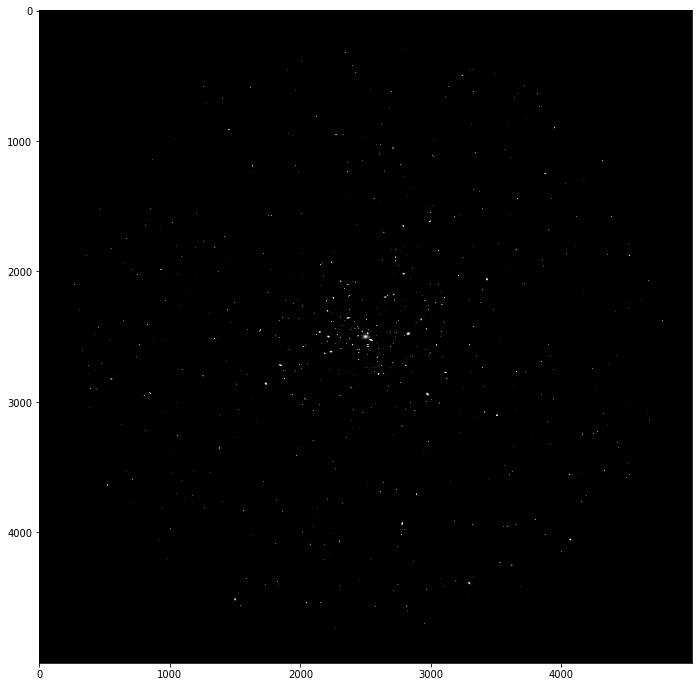

In [106]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cc = canvas.array
ax.imshow(np.arcsinh(cc) / cc, cmap=plt.cm.gray_r)
# ax.imshow(canvas.array)

fig.savefig('cluster_only_test_G.png', dpi=300)

In [22]:
gal_image = galsim.ImageF(canvas_size, canvas_size, scale=pixel_scale)
for i in np.arange(1000):
    bdf_pars = np.zeros(7)
    bdf_pars[2] = catalog["G1"][i]
    bdf_pars[3] = catalog["G2"][i]
    bdf_pars[4] = catalog["TSIZE"][i]
    bdf_pars[5] = catalog["FRACDEV"][i]
    bdf_pars[6] = catalog["FLUX_G"][i]
    galmaker = ngmix.gmix.GMixBDF(bdf_pars)
    gs_profile = galmaker.make_galsim_object()
    final_gal = galsim.Convolve([psf, gs_profile])
    stamp_size = final_gal.getGoodImageSize(pixel_scale)
    
    xx = catalog['X'][i] - 2500.
    yy = catalog['Y'][i] - 2500.
    
    
    
    x_cen = np.floor(xx)
    y_cen = np.floor(yy)

    offset = (xx - x_cen, yy - y_cen)
    b = galsim.BoundsI(x_cen - stamp_size / 2+1  , x_cen + stamp_size/ 2,
                       y_cen - stamp_size / 2 +1,  y_cen + stamp_size / 2)
    sub_gal_image = gal_image[b]
    final_gal.drawImage(sub_gal_image, offset=offset, add_to_image=True)
    
# sky_level_pixel = sky_level * pixel_scale**2
# noise = galsim.PoissonNoise(ud, sky_level=sky_level_pixel)
# gal_image.addNoiseSNR(noise, 100)    

/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


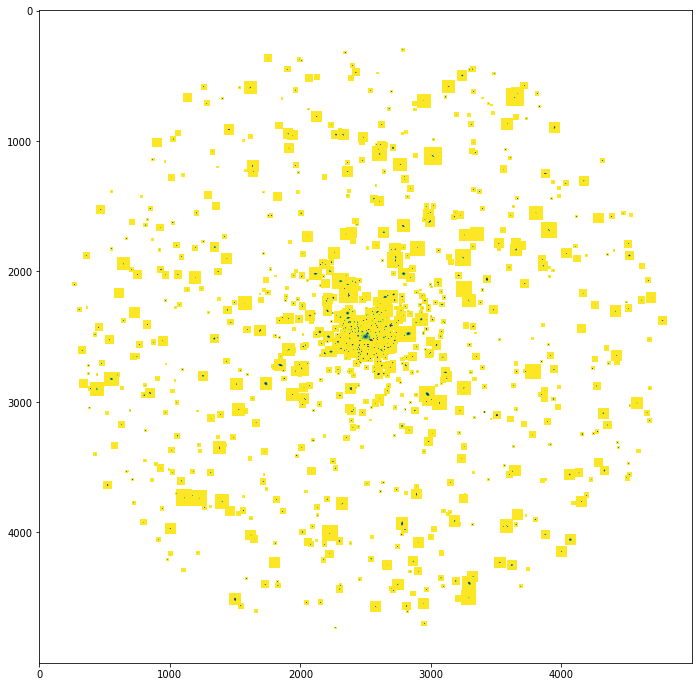

In [20]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(np.arcsinh(gal_image.array) / gal_image.array)
fig.savefig('postate_stamp_outline.png', dpi=300)

/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


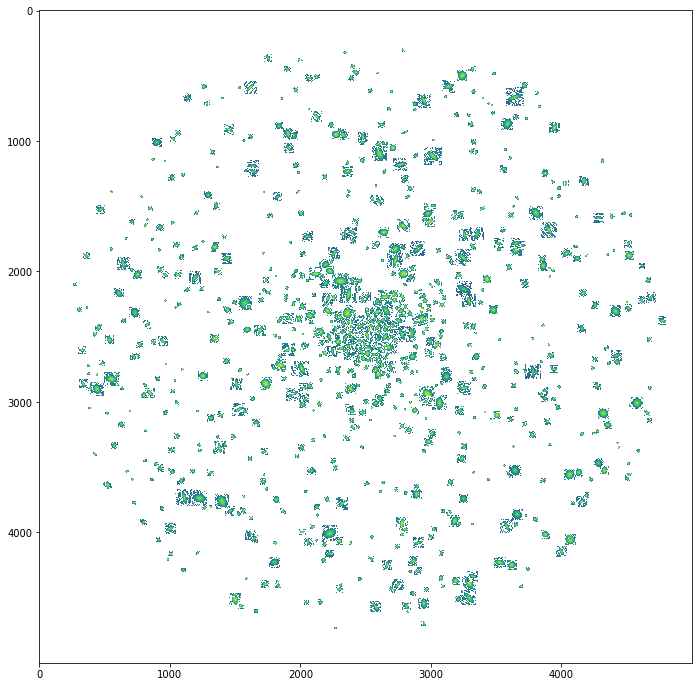

In [302]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(np.log(gal_image.array))

In [260]:
offset

(0.6902590132613113, 0.03132190738324425)

In [231]:
b = galsim.BoundsI(2500 - stamp_size / 2+1  , 2500 + stamp_size/ 2,
                   2500 - stamp_size / 2 +1, 2500 + stamp_size / 2)
sub_gal_image = gal_image[b]
# sub_psf_image = psf_image[b]

In [246]:
bdf_pars = np.zeros(7)
bdf_pars[2] = catalog["G1"][i]
bdf_pars[3] = catalog["G2"][i]
bdf_pars[4] = catalog["TSIZE"][i]
bdf_pars[5] = catalog["FRACDEV"][i]
bdf_pars[6] = catalog["FLUX_G"][i]
galmaker = ngmix.gmix.GMixBDF(bdf_pars)
gs_profile = galmaker.make_galsim_object()

In [247]:
final_gal = galsim.Convolve([psf, gs_profile])

In [258]:
final_gal.getGoodImageSize(0.264)

332

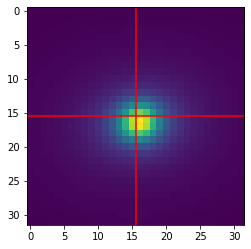

In [245]:
final_gal.drawImage(sub_gal_image, offset=(0.5, 0.9))
plt.imshow(sub_gal_image.array)
plt.axvline(15.5, color='red')
plt.axhline(15.5, color='red')

In [200]:
sub_gal_image.array.shape

(10, 10)

In [201]:
sub_gal_image

galsim.Image(bounds=galsim.BoundsI(xmin=2496, xmax=2505, ymin=2496, ymax=2505), array=
array([[0.00095245, 0.00108771, 0.00121561, 0.00132504, 0.00140435,
        0.00144383, 0.00143822, 0.00138832, 0.00130072, 0.00118585],
       [0.00117489, 0.00135873, 0.0015365 , 0.00169165, 0.00180573,
        0.00186259, 0.00185335, 0.00177957, 0.00165261, 0.00148974],
       [0.0014325 , 0.00168072, 0.00192745, 0.00214841, 0.0023141 ,
        0.00239709, 0.00238184, 0.00227143, 0.00208613, 0.0018549 ],
       [0.00172004, 0.00205116, 0.0023915 , 0.0027065 , 0.00294914,
        0.00307185, 0.00304655, 0.00287955, 0.00260787, 0.00228061],
       [0.00202401, 0.00245661, 0.00291897, 0.00336461, 0.00371998,
        0.00390245, 0.00386066, 0.00360746, 0.00321089, 0.00275346],
       [0.00231977, 0.00286608, 0.00347492, 0.00408878, 0.00459804,
        0.00486449, 0.00479756, 0.00442203, 0.00385788, 0.00323774],
       [0.0025712 , 0.00322663, 0.00398542, 0.00478304, 0.00546929,
        0.00583458, 0.0

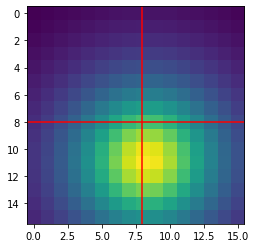

In [181]:
plt.imshow(sub_gal_image.array)
plt.axvline(8, color='red')
plt.axhline(8, color='red')

In [39]:
# Great08 randomized the locations of the two galaxies in each pair,
# but for simplicity, we just do them in sequential postage stamps.
if first_in_pair:
    # Use a random orientation:
    beta = ud() * 2. * math.pi * galsim.radians

    # Determine the ellipticity to use for this galaxy.
    ellip = 1
    while (ellip > gal_ellip_max):
        # Don't do `ellip = math.fabs(gd())`
        # Python basically implements this as a macro, so gd() is called twice!
        val = gd()
        ellip = math.fabs(val)

    # Make a new copy of the galaxy with an applied e1/e2-type distortion
    # by specifying the ellipticity and a real-space position angle
    ellip_gal = gal.shear(e=ellip, beta=beta)

    first_in_pair = False
else:
    # Use the previous ellip_gal profile and rotate it by 90 degrees
    ellip_gal = ellip_gal.rotate(90 * galsim.degrees)

    first_in_pair = True

# Apply the gravitational reduced shear by specifying g1/g2
this_gal = ellip_gal.shear(g1=gal_g1, g2=gal_g2)

# Apply a random shift_radius:
rsq = 2 * shift_radius_sq
while (rsq > shift_radius_sq):
    dx = (2*ud()-1) * shift_radius
    dy = (2*ud()-1) * shift_radius
    rsq = dx**2 + dy**2

this_gal = this_gal.shift(dx,dy)
# Note that the shifted psf that we create here is purely for the purpose of being able
# to draw a separate, shifted psf image.  We do not use it when convolving the galaxy
# with the psf.
this_psf = psf.shift(dx,dy)

# Make the final image, convolving with the (unshifted) psf
final_gal = galsim.Convolve([psf,this_gal])

In [40]:
final_gal.drawImage(sub_gal_image)


galsim.Image(bounds=galsim.BoundsI(xmin=1, xmax=39, ymin=1, ymax=39), array=
array([[ 1.00195345e-10,  1.71156103e-10,  1.00161067e-10, ...,
        -2.04529067e-11, -8.08988154e-11, -1.02329242e-10],
       [ 1.92849445e-10,  1.00885619e-10,  1.43582049e-10, ...,
        -3.19688408e-11,  1.36285653e-11, -8.72344974e-11],
       [ 1.21451793e-10,  1.39772693e-10,  1.46380810e-10, ...,
         7.09298037e-11, -2.51849496e-11,  4.40228375e-11],
       ...,
       [ 5.71905578e-11,  6.17704637e-11,  1.97868347e-10, ...,
         9.65802091e-11,  4.54265479e-11,  1.30952083e-10],
       [ 4.47197626e-11,  5.74499684e-11,  1.61467107e-11, ...,
         4.68863524e-11,  1.41139683e-10,  1.05344060e-10],
       [-6.60015306e-11, -6.20980264e-13,  5.69631807e-11, ...,
         1.48905069e-10,  8.73418768e-11,  1.23303853e-10]], dtype=float32), wcs=galsim.PixelScale(1.0))

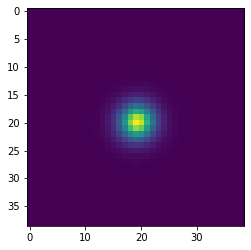

In [41]:
plt.imshow(sub_gal_image.array)

In [11]:
reload(gen)

<module 'synthetic.render.generator' from '/home/moon/vargatn/DES/SYNTHETIC/synthetic/synthetic/render/generator.py'>

In [12]:
ms = gen.MockupSurvey()

In [13]:
ms.draw()

In [43]:
import ngmix

In [46]:
ngmix.gmix.GMixBDF()

AssertionError: send pars=